# **Introduction**

Air pollution is affected by the weather due to the moisture and the precipitation of the air affecting the concentration of pollutants through factors such as humidity, temperature, and particulate matter. For example, when it rains, particulate matter such as PM 2.5 is carried out of the air through rain droplets into groundwater, and gaseous pollutants may dissolve into the water.

We’re choosing the air particles PM 2.5 because the variable frequently emerges in regards to the air pollution in Beijing, specifically the region Tiantan because of its population consisting of both locals and tourists creating a generous amount of people to be affected by. Through this data analysis, we can predict the air condition in the region and the impact it has on the community and how we can further improve it.

Some researchers conducted two separate studies to investigate the relationship between PM2.5 concentration and meteorological factors. Chen et al. conducted the first study in the Nanjing urban area and found that PM2.5 concentration was negatively correlated with wind speed, temperature, relative humidity, and precipitation (5–16). The second study was conducted by Li et al. in the Sichuan Basin, found that PM2.5 concentration was negatively correlated with wind speed and air temperature, and positively correlated with air pressure (153–159). In both studies, they found a weak correlation between PM2.5 concentration and relative humidity. Therefore, in this project we will use these 5 variables (the temperature (C°), pressure (hPa), dew point temperature (C°), precipitation (mm), wind speed (m/s)) to answer **how do the predictors as meteorological factors correlate to the pollutant PM2.5 and which of those predictors would have the most impact on the concentration of PM 2.5 ?**

The dataset itself consists of hourly concentration of air pollutants and meteorological variables from 12 air-monitoring stations in Beijing between March 1, 2013 and February 28, 2017 (Zhang, S. et al.).

# **Methods**

The object that we are going to predict in this data set is the pollutant PM 2.5 with the 5 predictors we're planning to apply are one of Temperature (TEMP), Pressure (PRES), Dew Point Temperature (DEWP), Rain (RAIN), or Wind Speed (WSPM) in which we will determine by doing a **Forward Selection R**. By doing so, we’ll be able to determine which predictor has the minimum *Root Mean Square Error (RMSE)* as a single predictor and use that outcome to perform a **KNN Regression** of PM2.5 against the chosen predictor. We will then analyze the strength of the effect that predictor has on the concentration of PM2.5.

In the original data set, there is a variable called Wind Direction (wd) in which we will not take into consideration in the prediction since it is a categorical variable therefore is not integrated with the plot.

Additionally, seasonal weather may influence the prediction, however this is not our topic of study. Therefore all time variables such as year, month, day, hour are dropped to prevent interference with our regression plot although we will attempt to group the data points by year, month, and day.

We plan to normalize our data to make sure that certain variables with large absolute quantities such as PM 2.5 do not receive undue weight.

In conclusion, the variables used for the data set are as such :

Objects for Regression: PM 2.5

Possible Predictors:

Temperature (TEMP)
Pressure (PRES)
Dew Point Temperature (DEWP)
Rain (RAIN)
Wind Speed (WSPM)
We will visualize the results through a regression plot on pollutants such as PM 2.5 in which we will create a regression plot for the predictor in relation to our pollutant.

## **Code**

### A. Load the Library and Data

#### **1.  Load the Library**

In [189]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(testthat)
library(digest)
library(tidymodels)
library(GGally)
library(broom)
library(infer)
library(cowplot)

#### **2.  Load the Data**

In [211]:
weather_data <- read.csv("https://www.dropbox.com/s/2vo6d6ynrsxpavp/PRSA_Data_Tiantan_20130301-20170228.csv?dl=1")

In [213]:
#Table 2.1 Weather Data
weather_data

No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,2013,3,1,0,6,6,4,8,300,81,-0.5,1024.5,-21.4,0,NNW,5.7,Tiantan
2,2013,3,1,1,6,29,5,9,300,80,-0.7,1025.1,-22.1,0,NW,3.9,Tiantan
3,2013,3,1,2,6,6,4,12,300,75,-1.2,1025.3,-24.6,0,NNW,5.3,Tiantan
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35062,2017,2,28,21,18,32,4,48,500,48,10.8,1014.2,-13.3,0,NW,1.1,Tiantan
35063,2017,2,28,22,15,42,5,52,600,44,10.5,1014.4,-12.9,0,NNW,1.2,Tiantan
35064,2017,2,28,23,15,50,5,68,700,21,8.6,1014.1,-15.9,0,NNE,1.3,Tiantan


### B. Tidy the Data & GGPairs

#### **1.  Tidy the Data**

In [215]:
tidy_data <- weather_data |> group_by(year, month, day) |> 
summarize(TEMP = mean(TEMP), PRES = mean(PRES), DEWP = mean(DEWP), RAIN = mean(RAIN), WSPM = mean(WSPM), PM2.5 = mean(PM2.5)) |> ungroup() |> select(-year, -month, -day) |> na.omit()

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


In [217]:
#Table 1.1 Tidied Data
tidy_data

TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3250000,1028.783,-21.46667,0,3.3083333,8.62500
0.4916667,1028.850,-16.96250,0,0.7916667,31.70833
4.9875000,1016.458,-12.31250,0,1.2250000,98.04167
⋮,⋮,⋮,⋮,⋮,⋮
7.245833,1018.812,-10.754167,0,1.825000,10.20833
7.208333,1020.337,-8.258333,0,1.566667,24.16667
10.958333,1014.888,-12.783333,0,2.058333,14.87500


#### **2.  GGPairs Plot of Tidy Data**

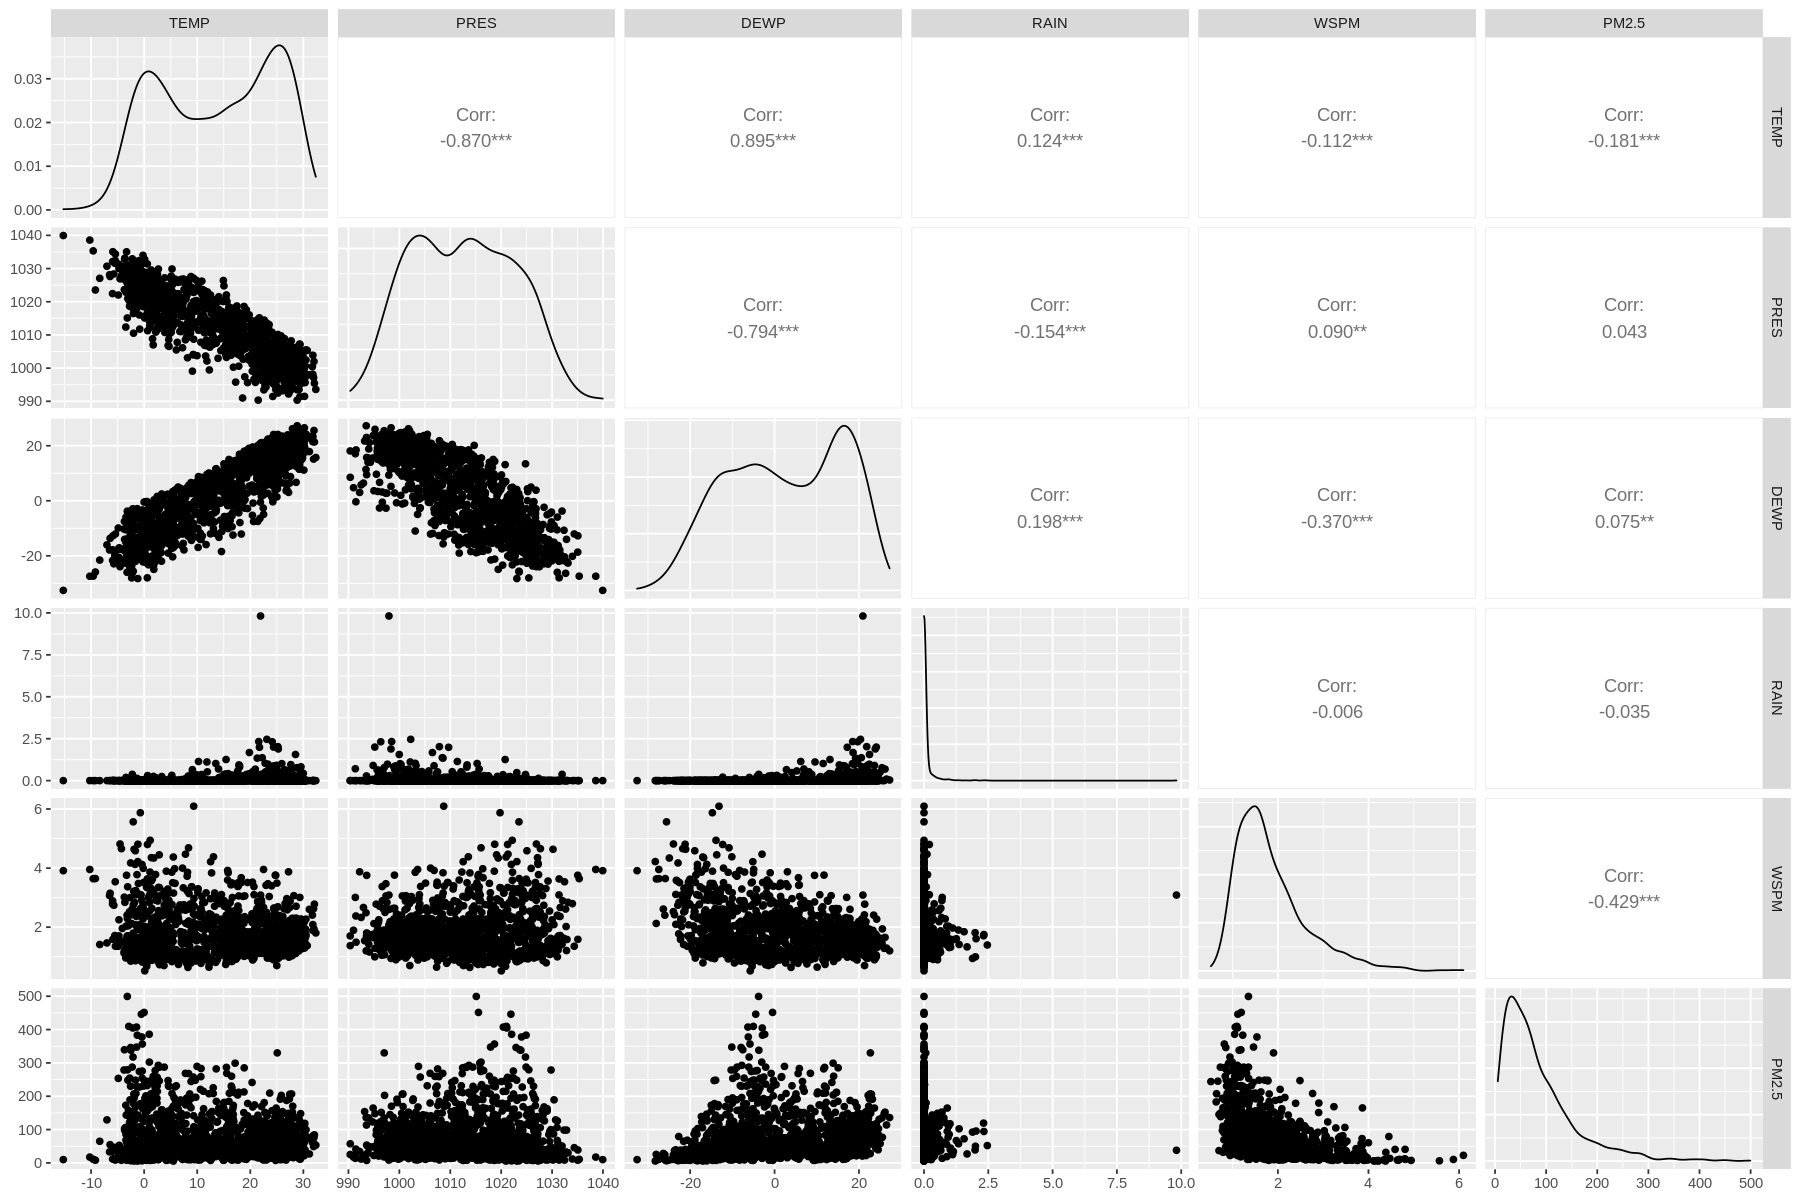

In [219]:
#Figure 2.1 Relationship between PM2.5 and all of the Predictors
options(repr.plot.height = 10, repr.plot.width = 15)
ggpairs(tidy_data)

After we loaded and the tidied up the data set in R, we decided to visualize it with the *ggpairs* function. Here we see in these graphs that the relationship between the object of prediction, PM2.5 and its 5 predictors *Temperature, Pressure, Dew Point, Rain, and Wind Speed* vary, with each variable also having its own relationship with one another. We can take a look specifically on the last row where there's a direct relationship between the variable PM2.5 with its predictors.

On the final row, we can see that as the values of PM2.5 increases, the predictors have the relationships as such :
- The variable Temperature has a sudden jump in the beginning and then decreases to then remain stable throughout the rest of the graph.
- The variable Pressure has a stable rate throughout the graph with a few values increasing towards the middle-end.
- The variable Dew Point increases relatively fast until the middle of the graph where the values are at its peak as it decreases after to reach a stable rate.
- The variable Rain has a spike with a peak at the very beginning of the graph, proceeds to drop to a small value and decreases to 0 throughout the rest of the graph. Additionally, there's a singular value by the end of it.
- The variable Wind Speed starts immediately at a high point of the graph increasing towards its peak and has a stable decrease until the end of the graph.

### C. Preminilary Data

#### **1. Split the Data, Create a Training and a Testing Data**

In [221]:
set.seed(2000) 

weather_split <- initial_split(tidy_data, prop = 0.75, strata = PM2.5)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)

In [ ]:
#Table 1.1 Training Weather Data 
weather_training

In [ ]:
#Table 1.2 Testing Weather Data 
weather_testing

#### **2. Summary Statistics**

In [251]:
#Table 2.1 Summary Statistics for the Predictors on the Training Data
weather_predictors <- weather_training |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |>
map_dfr(mean, na.rm = TRUE) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "Mean")

Standard_Deviation <- weather_training |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |>
map_dfr(sd, na.rm = TRUE) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "Standard Deviation") |> pull(2)

Median <- weather_training |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |> 
map_dfr(median, na.rm = TRUE) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "Median") |> pull(2)

summary_statistics <- data.frame(weather_predictors, Standard_Deviation, Median)
summary_statistics

Predictors,Mean,Standard_Deviation,Median
<chr>,<dbl>,<dbl>,<dbl>
TEMP,1.356812e+01,10.9453435,14.814583
PRES,1.012674e+03,9.8450179,1012.689583
DEWP,2.313399e+00,13.7388563,2.162500
RAIN,5.434028e-02,0.2083190,0.000000
WSPM,1.859638e+00,0.7782157,1.666667


#### **3. Forward Selection**

In [254]:
#Table 3.1 RMSEs for the Predictors
# create an empty tibble to store the results
names <- colnames(tidy_data |> select(-PM2.5))
rmses <- tibble(size = integer(), 
                     model_string = character(), 
                     rmse = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("regression")

# create a 5-fold cross-validation object
weather_vfold <- vfold_cv(weather_training, v = 5, strata = PM2.5)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("PM2.5", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        weather_recipe <- recipe(as.formula(model_string), 
                                data = tidy_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        
        # tune the KNN regression model with these predictors, 
        # and collect the RMSE for the best K
        acc <- workflow() |>
            add_recipe(weather_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = weather_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "rmse") |>
            summarize(mx = min(mean))
        
        result <- acc$mx |> unlist()
         #add this result to the dataframe
        accs[[j]] <- result
        models[[j]] <- model_string
        
    }
    jstar <- which.min(unlist(accs))
    rmses <- rmses |> 
            add_row(size = i, 
            model_string = models[[jstar]], 
              rmse = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [255]:
#Table 3.2 Lowest RMSE
rmses

size,model_string,rmse
<int>,<chr>,<dbl>
1,PM2.5 ~ WSPM,64.68607
2,PM2.5 ~ WSPM+DEWP,59.18544
3,PM2.5 ~ WSPM+DEWP+TEMP,54.01019
4,PM2.5 ~ WSPM+DEWP+TEMP+PRES,51.83043
5,PM2.5 ~ WSPM+DEWP+TEMP+PRES+RAIN,50.95750


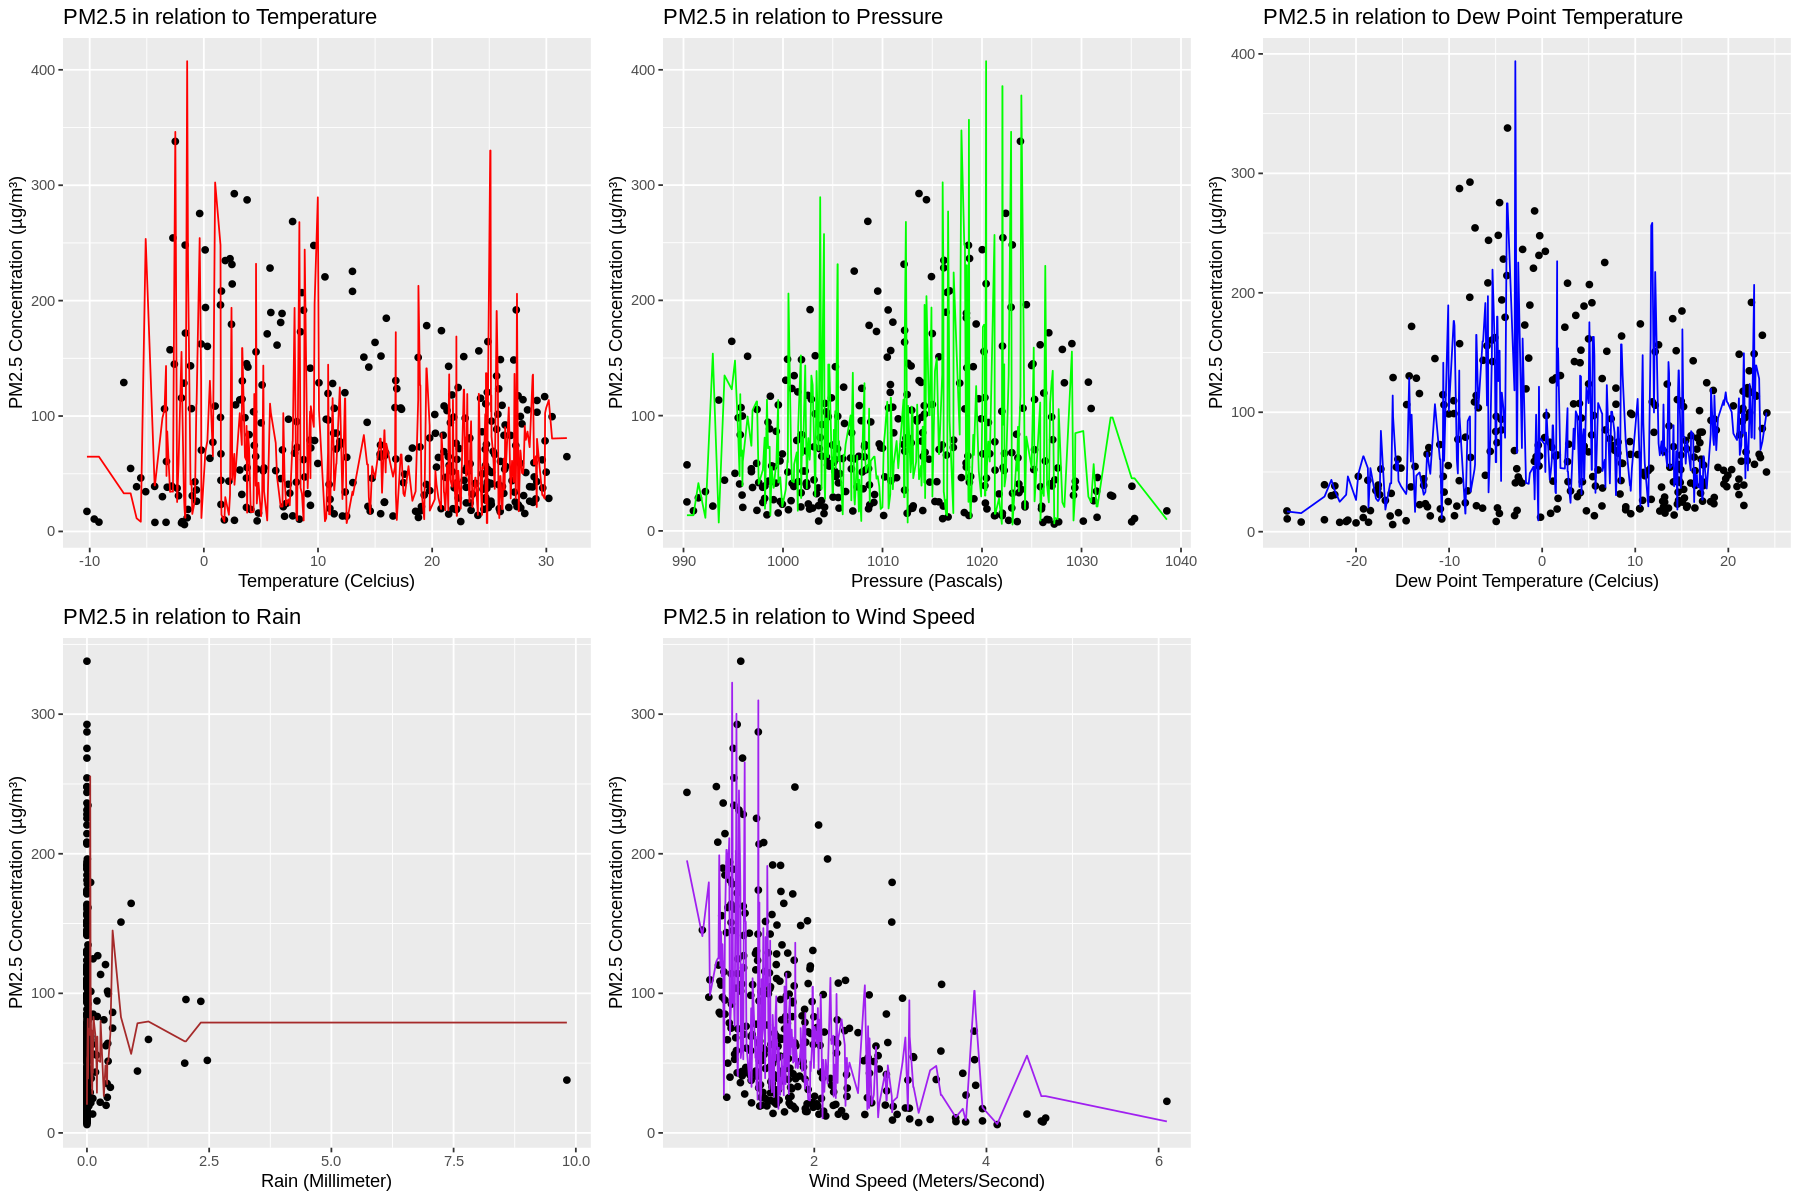

In [256]:
# Figure 3.1 Model performance for all single predictors
names <- colnames(tidy_data |> select(-PM2.5))
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     rmse = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("regression")

weather_vfold <- vfold_cv(weather_training, v = 5, strata = PM2.5)

n_total <- length(names)

# stores selected predictors
selected <- c()
aesmaps <- list("TEMP", "PRES", "DEWP", "RAIN", "WSPM")

labels <- list("Temperature (Celcius)", "Pressure (Pascals)", "Dew Point Temperature (Celcius)", "Rain (Millimeter)", "Wind Speed (Meters/Second)")
colors <- list("red", "green", "blue", "brown", "purple")
plots <- list()
for (j in 1:5) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])

        # create a recipe from the model string
        weather_recipe <- recipe(as.formula(paste("PM2.5 ~", aesmaps[[j]])), 
                                data = tidy_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
    
        metrics <- workflow() |>
            add_recipe(weather_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = weather_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "rmse")
        bestk <- metrics |> slice(1) |> pull(neighbors)
        final_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = bestk) |>
         set_engine("kknn") |>
         set_mode("regression")
        
        final_fit <- workflow() |>
            add_recipe(weather_recipe) |>
            add_model(final_spec) |>
            fit(weather_training)
        preds <- final_fit |>
             predict(weather_testing) |>
             bind_cols(weather_testing)
    plot <- ggplot(data = preds, eval(parse(text = paste("aes(x = ", aesmaps[[j]], ", y = PM2.5)")))) + geom_point() + 
            geom_line(data = preds, mapping = eval(parse(text = paste("aes(x = ", aesmaps[[j]], ", y = .pred)"))), color = colors[[j]]) +
            labs(x = labels[[j]], y = "PM2.5 Concentration (µg/m³)") +
            ggtitle(paste("PM2.5 in relation to", gsub("\\s*\\([^\\)]+\\)","",labels[[j]])))
            
    plots <- append(plots, list(plot)) }
plotgrid <- plot_grid(plotlist = plots)
plotgrid

Legend: 
Red Graph: PM2.5 in relation to Temperature
Green Graph: PM2.5 in relation to Pressure
Blue Graph: PM2.5 in relation to Dew Point Temperature
Brown Graph: PM2.5 in relation to Rain
Purple Graph: PM2.5 in relation to Wind Speed

### D. KNN Regression

#### **1. Load the Previously Created Training and Testing Data**

In [ ]:
#Table 1.1 Training Weather Data 
weather_training

In [ ]:
#Table 1.2 Testing Weather Data 
weather_testing

#### **2.  Create K-Nearest Neighbor Specification and Recipe**

In [ ]:
#Perform KNN regression on CO using the predictor Wind_Speed
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")

weather_recipe <- recipe(PM2.5 ~ WSPM, data = weather_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

In [ ]:
#Recipe 2.1 Weather Recipe
weather_recipe

#### **3.  Create Workflow using the Previously Made Recipe and Specification**

In [ ]:
set.seed(2000) 
weather_vfold <- vfold_cv(weather_training, v = 5, strata = PM2.5)

weather_workflow <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_spec)

In [ ]:
#Workflow 3.1 Weather Workflow
weather_workflow

#### **4.  Results of Workflow Computation and Finding the Best K-Nearest Neighbour Values**

In [ ]:
set.seed(2000)

gridvals <- tibble(neighbors = seq(from = 1, to = 200))

weather_results <- weather_workflow|> 
                  tune_grid(resamples = weather_vfold, grid = gridvals) |>
                  collect_metrics() 

In [ ]:
#Table 4.1 Weather Workflow Data Results
weather_results

In [ ]:
weather_min <- weather_results |>
            filter(.metric == "rmse") |>
            arrange(mean) |> 
            slice(n = 1)

In [ ]:
#Table 4.2 Weather with Best K-Nearest Neighbours and Estimation Values
weather_min

#### **5.  Repetition of Specification and Workflow Computation using the Results Concluded**

In [ ]:
k_min <- weather_min |>
          pull(neighbors)

weather_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                    set_engine("kknn") |>
                    set_mode("regression")

weather_best_fit <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_best_spec) |>
                    fit(data = weather_training)

weather_summary <- weather_best_fit |>
                    predict(weather_testing) |>
                    bind_cols(weather_testing) |>
                    metrics(truth = PM2.5, estimate = .pred) |>
                    filter(.metric == "rmse")

In [ ]:
#Figure 5.1 K-Nearest Neighbour Value
k_min

In [ ]:
#Table 5.1 Minimum Root Mean Square Error (RMSE) Value
weather_summary

#### **6.  Produce the Calculated Predicted Values against The Object of Prediction itself (PM2.5):** *Using the Trained Workflow on a new unseen Dataset (Testing Weather Data)*

In [ ]:
weather_preds <- weather_best_fit |>
                predict(weather_testing) |>
                bind_cols(weather_testing)

In [ ]:
#Table 6.1 Weather Testing Data Prediction
weather_preds

#### **7.  Visualization of Predicted Values on every Predictor**

In [ ]:
weather_plot <- ggplot(weather_preds, aes(x = WSPM, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = WSPM, y = .pred),
              color = "blue") +
    xlab("Wind Speed") + 
    ylab("PM2.5") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

In [ ]:
#Figure 7.1 K-NN Regression: Weather Plot
weather_plot

The blue line shows that the peak of PM2.5 is at around *y = ~160* and it decreases (with a steep slope) starting with x (wind speed) at around 0.9 m/s. This trend lasts until x at around 1.7 m/s when the PM2.5 concentration experiences a minor recovery and then the decreasing trend starts to slow down (though still decreasing). When the wind speed continues to increase after x at around 3.7 m/s, we have much less samples and the line starts to level off.

### Discussion

1. Summarize what you found

In [ ]:
#Table 1.1 Accuracy Table
accuracies

**Here we see that with the Forward Selection R technique, we found that the most impactful single predictor was Wind Speed (WSPM) with the RMSE value of RMSE = ~64.17.**

In [ ]:
#Table 1.2 K-Nearest Neighbors = 107
weather_min

**We found that the best K-Nearest Neighbour value, which has the least RMSE value from the training set, in constructing the model for predicting the unknown PM2.5 concentration is *k = 107*.**

In [ ]:
#Table 1.3 Minimum RMSE Values
weather_summary

**As the number of RMSE grows larger, the predicted values would be further than the actual values meanwhile if the number decreases then the predicted values would grow closer to the actual values. The RMSE value that we received was *55.05* which we can conclude as the minimum *Root Mean Square Error* value.**

In [ ]:
#Table 1.4 Prediction Values on Testing Data
weather_preds

**ELABORATION**

In [ ]:
#Table 1.5 Weather Regression Plot
weather_plot

**This is the plot showing the negative relationship between PM2.5 and wind speed where as PM2.5 decreases WSPM decreases as well, there is an exponential decrease in the value of WSPM is at ± 1 m/s which continues to then decrease in a stable rate until it reaches a rate that is almost flat. The plot shows that it’s not over-oscillating nor under-oscillating (straight line), which means it’s not over-fitting nor underfitting and is overall a good fit for the data set.**

2. Discuss whether this is what you expected to find?

- What we expected to originally find.
An article done on air quality measurement back in 2021, researchers found that higher wind speeds often result in the more widespread dispersal of air pollutants, leading to lower concentrations of air pollution in areas with stronger winds. We can also clarify this by looking at the original ggpair plot where as the object PM2.5 and predictor WSPM have the largest absolute correlation value of 0.429 and also as PM2.5 decreases in value, WSPM decreases in number as well. Meanwhile, other predictors on the plot nor on any research that we did prove to be more impactful on the object PM2.5. Therefore, in this project, we expected to find the correlations between certain meteorological conditions and the quantity of certain air pollutant PM2.5 where the predictor WSPM, has a more significant relationship with the pollutant than the others. 

- What we actually found.
In step C we found that the predictor wind speed indeed has the greatest accuracy which supports our hypothesis that WSPM is the best predictor among the 5 meteorological conditions. Then we perform the model based on WSPM to predict the unknown PM2.5 concentrations in the testing dataset and received the RMSE value of 55.05 and the overall trend of PM2.5 against wind speed as the plot shows.

3. What impact could such findings have?

Discovering the relationship between air pollutants and weather conditions may provide insight into methods of mitigating the effects of air pollution. This can help to advance active pollution reduction technologies such as carbon capture or discovering better methods of reducing the penetration of PM 2.5 into households. Since we can tentatively predict the weather, we may be able to use meteorology combined with behavioral techniques to reduce air pollution such as by using green energy during periods of low wind speed.

4. What future questions could this lead to?

- Is the air pollution temporarily reduced or permanently removed from the air through weather events?
**The pollutant, PM 2.5, may be integrated into the environment such as how smoke is washed into the soil and turned into ash.**

- Does the pollution from air pollution become integrated into the environment through other means such as water pollution?
**Certain types of toxic pollutants may be washed into the water supply, such as meteorological conditions such as acid rain.**

- How might meteorological conditions be stimulated or controlled to reduce air pollution in cities?
**Techniques such as rain cloud seeding may be available to reduce the concentration of pollutants during high concentration of pollutants.**

### References

1. Chen, Tao, et al. “Spatial and Temporal Variations of PM2.5 and Its Relation to Meteorological Factors in the Urban Area of Nanjing, China.” MDPI, Multidisciplinary Digital Publishing Institute, 16 Sept. 2016, https://www.mdpi.com/1660-4601/13/9/921 
2. Li, Yang, et al. “Variations in PM10, PM2.5 and PM1.0 in an Urban Area of the Sichuan Basin and Their Relation to Meteorological Factors.” MDPI, Multidisciplinary Digital Publishing Institute, 9 Jan. 2015, https://www.mdpi.com/2073-4433/6/1/150
3. Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457
4. “Air Quality Measurements Series: Wind Speed and Direction.” Low-Cost Air Quality Monitoring &amp; Measurement, https://www.clarity.io/blog/air-quality-measurements-series-wind-speed-and-direction 
